# JUST PREDICT 1

Canon, -1.

In [ ]:
from datetime import datetime
print(datetime.now())

2023-03-11 21:02:23.531502


In [ ]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
print('GPU (if any):',device_name)

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    print('Running locally')
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print('Data directory:')
print(DATA_DIR)

GPU (if any): /device:GPU:0
Running on CoLab
Mounted at /content/drive/
Data directory:
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [ ]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
CFILTERS=64
FILTERSIZE=16
RCELLS=32
DCELLS=16
EPOCHS=12
FOLDS=5      
EMBED_DIMEN = 4 # arbitrary hyperparameter
MINLEN=200
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
CACHING = False   # have not worked out how to cache multiple cell lines
NUM_LINES = 15   # 15 to analyze all of them

Python 3.9.16
sklearn 1.2.1


In [ ]:
RCI_FILE       = 'train.lncRNA_RCI.csv'
SEQUENCE_FILE  = 'train.canon_lncRNA_transcripts.csv'
CACHE_SEQUENCE = 'cache.seq.pickle'
CACHE_IDS      = 'cache.id.pickle'
if CACHING:
    cache_seq = DATA_DIR+CACHE_SEQUENCE 
    cache_ids = DATA_DIR+CACHE_IDS 
    if isfile(cache_seq) and isfile(cache_ids):
        print('WARNING: this run will read sequence from cache.')
    else:
        print('INFO: this run will write sequence to cache.')

In [ ]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC

## Data Load

In [ ]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load from RCI csv file.
        Return dict with keys=gene:str and values=RCI:float.
        '''
        gene_to_rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = np.power(values,2)
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = 0.0
                        else:
                            log_mean = np.log2(big_mean) 
                        gene_to_rci[gene_id] = log_mean
        print('Number of RCI values loaded',len(gene_to_rci.keys()))
        return gene_to_rci

    def seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        allids=[]
        allseq=[]
        cache_seq = DATA_DIR+CACHE_SEQUENCE 
        cache_ids = DATA_DIR+CACHE_IDS 
        if CACHING and isfile(cache_seq) and isfile(cache_ids):
            # Warning: the cache may represent the wrong K.
            with open(cache_seq,'rb') as fin:
                allseq = pickle.load(fin)
            with open(cache_ids,'rb') as fin:
                allids = pickle.load(fin)
            return allids,allseq           
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # with version number
                    gene_id = fields[1]        # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    if seq_len>=MINLEN and seq_len<=MAXLEN and gene_id in gene_to_rci.keys():
                        allids.append( (gene_id,tran_id) )
                        if seq_len<MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                            seq_txt = seq_txt[:MAXLEN]
                        hot_vec = self.seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        if CACHING:
            with open(cache_seq,'wb') as fout:
                pickle.dump(allseq,fout)
            with open(cache_ids,'wb') as fout:
                pickle.dump(allids,fout)
        return allids,allseq

## Model

In [ ]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    cnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    pool_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    flat_layer = Flatten()
    dens_layer = Dense(DCELLS)
    drop_layer = Dropout(0.5)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    cnn.add(embed_layer)
    cnn.add(cnn1_layer)
    cnn.add(pool_layer)
    cnn.add(flat_layer)
    cnn.add(dens_layer)
    cnn.add(drop_layer)
    cnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    cnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return cnn

In [ ]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-03-11 21:03:08.237358
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4997, 4)           1028      
                                                                 
 conv1d (Conv1D)             (None, 4982, 64)          4160      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 621, 64)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 39744)             0         
                                                                 
 dense (Dense)               (None, 16)                635920    
                                                                 
 dropout (Dropout)           (None, 16)                0         
                             

## Training

In [ ]:
import gc
class CrossValidator():
    def __init__(self,epochs,folds,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.folds = folds
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False    
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def set_sequences(self, allids, allseq):
        # Keep IDs and sequences in same order.
        self.all_ids = allids  # pairs of (gene_id,tran_id)
        self.all_seqs = allseq  # may be vectors of K-mers
        genes = []
        for i in range(len(allids)):
            (one_gene,one_tran) = allids[i]
            genes.append(one_gene)
        self.all_genes = genes
            
    def set_rci_map(self, gene_to_rci):
        # The map is for fast lookup, not gene order.
        self.rci_map = gene_to_rci # map gene_id to RCI value
    
    def _get_gene_subset(self, sub_index):
        sub_genes = set()
        for index in sub_index:
            one_gene = self.all_genes[index]
            sub_genes.add(one_gene)
        return sub_genes   # this is a set: unordered with fast lookup
    
    def _get_X_y(self, gene_index, exclude_middle=False):
        # gene_index is ndarray with subset of indices of all_genes
        subsetX=[]
        subsetY=[]
        gene_subset = self._get_gene_subset(gene_index)
        for t in range(len(self.all_ids)):
            gene_id,tran_id = self.all_ids[t]
            if gene_id in gene_subset:
                oneX            = self.all_seqs[t]
                oneY            = self.rci_map[gene_id]
                if exclude_middle and oneY >= -2 and oneY <= 0:
                    # Exclude middle from train set only, for comparison to Yuan et al
                    continue
                subsetX.append(oneX)
                subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values):
        if self.mechanism == 'RCI_GMM':
            # The GMM is from sklearn not keras, so
            # would have to set its random_state separately. 
            gmm = GaussianMixture(n_components=2, verbose=0, 
                covariance_type='spherical', n_init=100) 
            gmm.fit(rci_values)
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def do_cross_validation(self,repetition):
        fold=0
        print()
        print(datetime.now())
        print('splitting')
        # KFold shuffles once before making the partitions
        splitter = KFold(n_splits=self.folds,shuffle=True) # random_state=42)
        splits = splitter.split(self.all_genes)
        splitter = None
        for train_index,valid_index in splits:
            fold += 1
            print('Repetition',repetition,'Fold',fold)
            X_train,y_rci = self._get_X_y(train_index) 
            self._prepare_threshold(y_rci)  # use train subset only!
            self._explain_threshold()
            y_train = self._apply_threshold(y_rci)
            X_valid,y_rci = self._get_X_y(valid_index)  
            y_valid = self._apply_threshold(y_rci) 
            y_rci = None
            cw = class_weight.compute_class_weight(
                'balanced', classes=[0,1], y=y_train)
            cwd = {0: cw[0], 1: cw[1]}

            model=build_model()
            print("FIT")
            print(datetime.now())
            history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
                class_weight=cwd, validation_data=(X_valid,y_valid) ) 
            
            print("PREDICT")
            print(datetime.now())
            yhat_pred=model.predict(X_valid, verbose=0)             
            yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)
            yhat_classes=np.ones(len(X_valid))  # just one!

            print('train class weights 1:0 %5.2f:%5.2f' % (cwd[1],cwd[0]))
            self._show_sizes('Train',y_train)
            self._show_sizes('Valid',y_valid)
            self._show_sizes('Predict',yhat_classes)

            accuracy = accuracy_score(y_valid, yhat_classes)*100.
            precision = precision_score(y_valid, yhat_classes)*100.
            recall = recall_score(y_valid, yhat_classes)*100.
            f1 = f1_score(y_valid, yhat_classes)*100.
            prc_Y, prc_X, prc_bins = precision_recall_curve(y_valid, yhat_pred)
            auprc = auc(prc_X,prc_Y)*100.
            auroc = roc_auc_score(y_valid, yhat_pred)*100.
            mcc = matthews_corrcoef(y_valid, yhat_classes)

            if PRETTY_PICTURES:
                pd.DataFrame(history.history).plot(figsize=(8,5))
                plt.grid(True)
                plt.gca().set_ylim(0,1)
                plt.show()

                print("Compute valiation accuracy")
                print('Valid sizes',X_valid.shape,y_valid.shape)
                print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
                print('Score threshold',self.score_threshold)

                count_ones= len(y_valid[y_valid==1])
                count_zeros= len(y_valid[y_valid==0])
                guess = max(count_ones,count_zeros) / len(y_valid)
                plt.plot(prc_X, prc_Y, marker='.')
                plt.plot([0, 1], [guess,guess], linestyle='--')
                plt.xlabel('Recall')
                plt.ylabel('Precision')
                plt.show()
                # ROC
                fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
                plt.plot(fpr, tpr, marker='.')
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                plt.show()

            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.2f%%' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
            self.cv_accuracy.append(accuracy)
            self.cv_precision.append(precision)
            self.cv_recall.append(recall)
            self.cv_f1.append(f1)
            self.cv_mcc.append(mcc)
            self.cv_auprc.append(auprc)
            self.cv_auroc.append(auroc)
            
            print(datetime.now())
            if self.quick_test:   
                print('Break -- this was for code testing only')
                break

            # There is a memory leak within the fit() command!
            # Each successive call to fit() consumes more memory.
            model = None
            history = None
            prc_Y = None
            prc_X = None
            prc_bins = None
            yhat_classes = None
            X_train = None
            y_train = None
            X_valid = None
            y_valid = None
            tf.keras.backend.clear_session()
            gc.collect()
            time.sleep(1)  # hope gc kicks in
        print()

        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


2023-03-11 21:03:08.644731
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence...
Loaded 4236 sequences.
Cross validation...

2023-03-11 21:03:20.806704
splitting
Repetition 1 Fold 1
Discriminator ZERO -1
FIT
2023-03-11 21:03:22.930096
PREDICT
2023-03-11 21:04:05.260846
train class weights 1:0  0.58: 3.57
Train 1:0 2914:474 86.01%
Valid 1:0 734:114 86.56%
Predict 1:0 848:0 100.00%


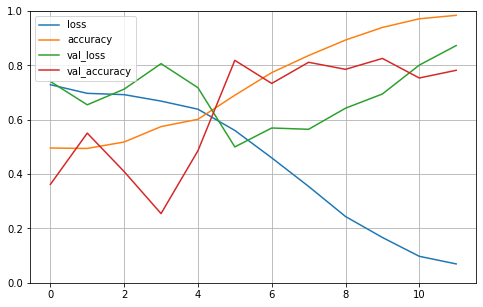

Compute valiation accuracy
Valid sizes (848, 4997) (848,)
Range of scores: 0.0045472663 to 1.0
Score threshold 0.5


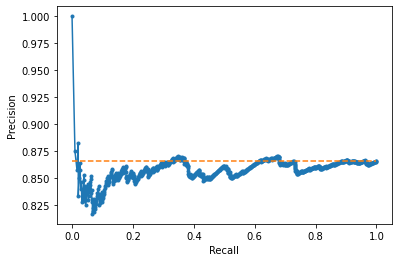

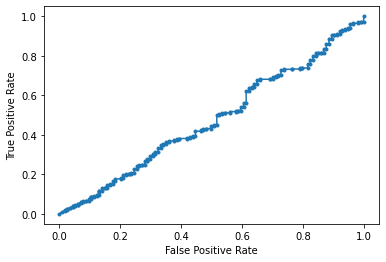

Accuracy: 86.56% Precision: 86.56% Recall: 100.00%
F1: 92.79% MCC: 0.00%
AUPRC: 85.80% AUROC: 47.78%
2023-03-11 21:04:06.257096
Repetition 1 Fold 2
Discriminator ZERO -1
FIT
2023-03-11 21:04:08.687843
PREDICT
2023-03-11 21:04:30.138119
train class weights 1:0  0.58: 3.61
Train 1:0 2919:470 86.13%
Valid 1:0 729:118 86.07%
Predict 1:0 847:0 100.00%


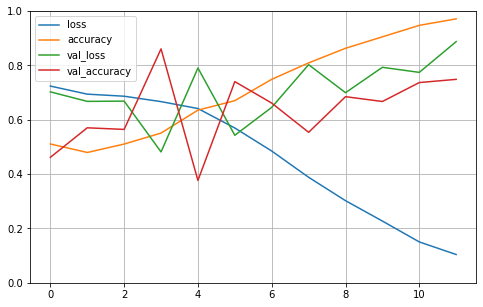

Compute valiation accuracy
Valid sizes (847, 4997) (847,)
Range of scores: 0.00019663096 to 1.0
Score threshold 0.5


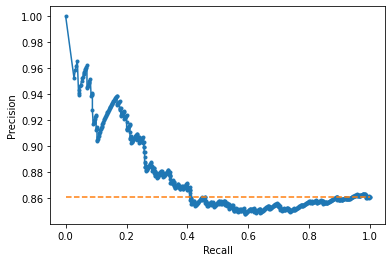

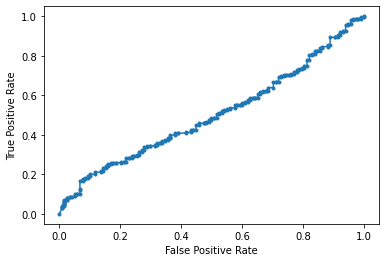

Accuracy: 86.07% Precision: 86.07% Recall: 100.00%
F1: 92.51% MCC: 0.00%
AUPRC: 87.84% AUROC: 50.49%
2023-03-11 21:04:31.200068
Repetition 1 Fold 3
Discriminator ZERO -1
FIT
2023-03-11 21:04:33.772384
PREDICT
2023-03-11 21:04:49.627083
train class weights 1:0  0.58: 3.55
Train 1:0 2912:477 85.93%
Valid 1:0 736:111 86.89%
Predict 1:0 847:0 100.00%


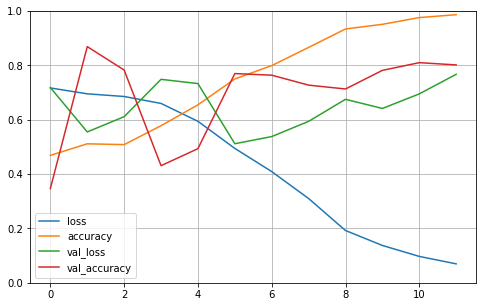

Compute valiation accuracy
Valid sizes (847, 4997) (847,)
Range of scores: 0.00012209725 to 1.0
Score threshold 0.5


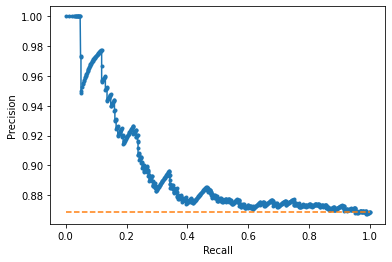

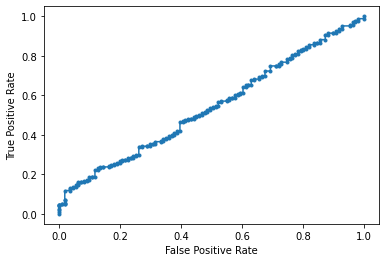

Accuracy: 86.89% Precision: 86.89% Recall: 100.00%
F1: 92.99% MCC: 0.00%
AUPRC: 89.60% AUROC: 54.15%
2023-03-11 21:04:50.349187
Repetition 1 Fold 4
Discriminator ZERO -1
FIT
2023-03-11 21:04:53.605700
PREDICT
2023-03-11 21:05:15.079590
train class weights 1:0  0.58: 3.57
Train 1:0 2914:475 85.98%
Valid 1:0 734:113 86.66%
Predict 1:0 847:0 100.00%


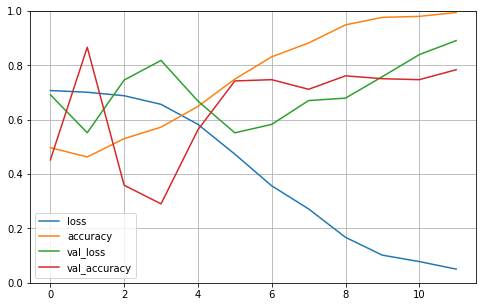

Compute valiation accuracy
Valid sizes (847, 4997) (847,)
Range of scores: 0.0015447631 to 1.0
Score threshold 0.5


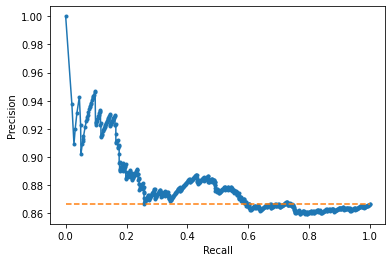

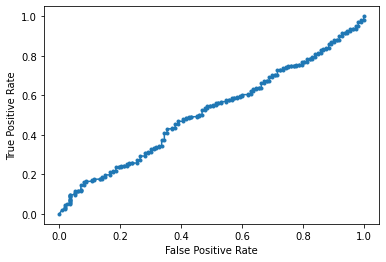

Accuracy: 86.66% Precision: 86.66% Recall: 100.00%
F1: 92.85% MCC: 0.00%
AUPRC: 88.18% AUROC: 51.48%
2023-03-11 21:05:15.970475
Repetition 1 Fold 5
Discriminator ZERO -1
FIT
2023-03-11 21:05:19.360422
PREDICT
2023-03-11 21:05:41.211393
train class weights 1:0  0.58: 3.72
Train 1:0 2933:456 86.54%
Valid 1:0 715:132 84.42%
Predict 1:0 847:0 100.00%


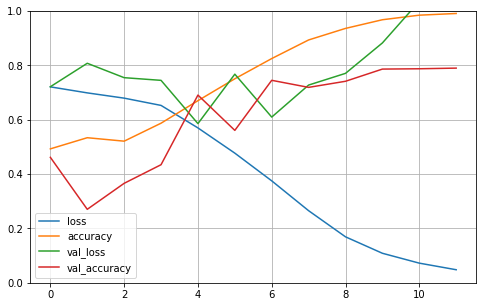

Compute valiation accuracy
Valid sizes (847, 4997) (847,)
Range of scores: 0.00033948588 to 1.0
Score threshold 0.5


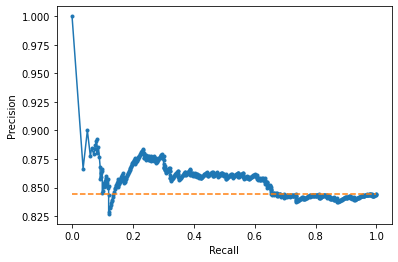

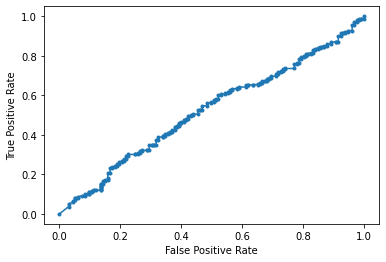

Accuracy: 84.42% Precision: 84.42% Recall: 100.00%
F1: 91.55% MCC: 0.00%
AUPRC: 85.89% AUROC: 52.33%
2023-03-11 21:05:42.195447


2023-03-11 21:05:43.566456
splitting
Repetition 2 Fold 1
Discriminator ZERO -1
FIT
2023-03-11 21:05:45.755817
PREDICT
2023-03-11 21:06:02.397673
train class weights 1:0  0.58: 3.64
Train 1:0 2923:465 86.28%
Valid 1:0 725:123 85.50%
Predict 1:0 848:0 100.00%


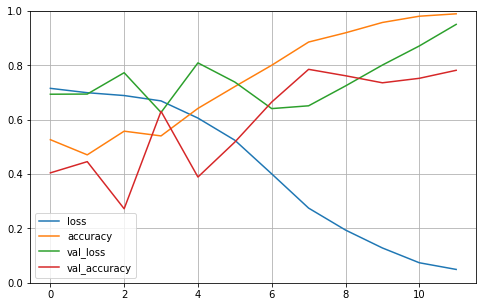

Compute valiation accuracy
Valid sizes (848, 4997) (848,)
Range of scores: 0.0010904091 to 1.0
Score threshold 0.5


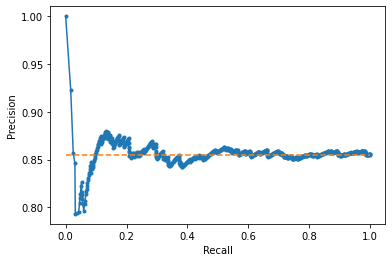

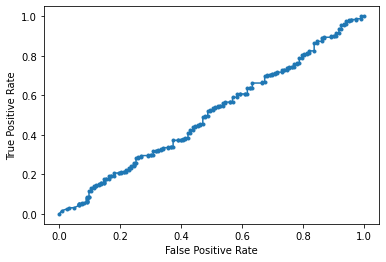

Accuracy: 85.50% Precision: 85.50% Recall: 100.00%
F1: 92.18% MCC: 0.00%
AUPRC: 85.66% AUROC: 50.35%
2023-03-11 21:06:03.109825
Repetition 2 Fold 2
Discriminator ZERO -1
FIT
2023-03-11 21:06:05.563745
PREDICT
2023-03-11 21:06:22.138323
train class weights 1:0  0.58: 3.60
Train 1:0 2918:471 86.10%
Valid 1:0 730:117 86.19%
Predict 1:0 847:0 100.00%


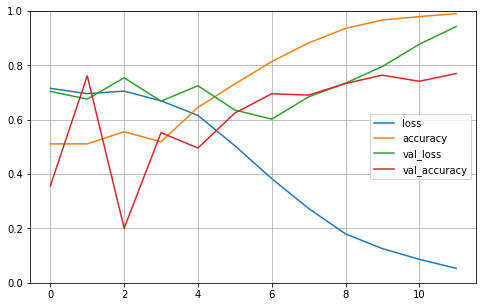

Compute valiation accuracy
Valid sizes (847, 4997) (847,)
Range of scores: 4.122635e-05 to 1.0
Score threshold 0.5


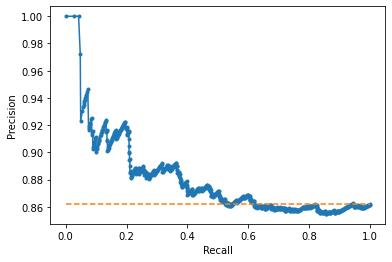

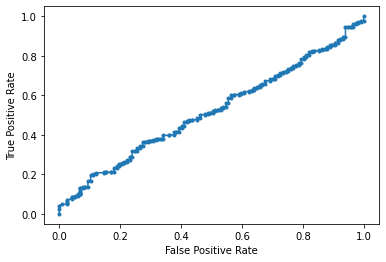

Accuracy: 86.19% Precision: 86.19% Recall: 100.00%
F1: 92.58% MCC: 0.00%
AUPRC: 88.20% AUROC: 51.84%
2023-03-11 21:06:22.866961
Repetition 2 Fold 3
Discriminator ZERO -1
FIT
2023-03-11 21:06:26.204534
PREDICT
2023-03-11 21:06:42.678792
train class weights 1:0  0.58: 3.69
Train 1:0 2930:459 86.46%
Valid 1:0 718:129 84.77%
Predict 1:0 847:0 100.00%


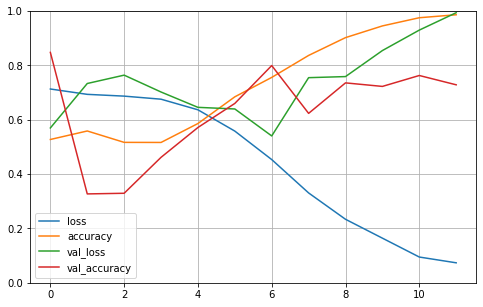

Compute valiation accuracy
Valid sizes (847, 4997) (847,)
Range of scores: 0.000107604756 to 0.9999999
Score threshold 0.5


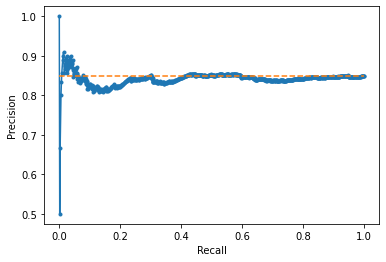

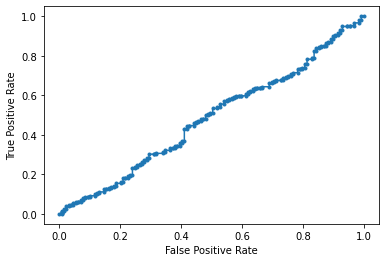

Accuracy: 84.77% Precision: 84.77% Recall: 100.00%
F1: 91.76% MCC: 0.00%
AUPRC: 84.18% AUROC: 48.44%
2023-03-11 21:06:43.417375
Repetition 2 Fold 4
Discriminator ZERO -1
FIT
2023-03-11 21:06:45.901724
PREDICT
2023-03-11 21:07:02.329495
train class weights 1:0  0.58: 3.61
Train 1:0 2919:470 86.13%
Valid 1:0 729:118 86.07%
Predict 1:0 847:0 100.00%


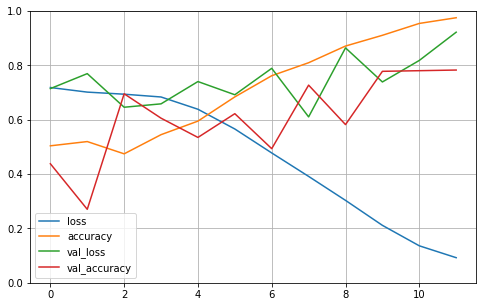

Compute valiation accuracy
Valid sizes (847, 4997) (847,)
Range of scores: 0.00036122138 to 1.0
Score threshold 0.5


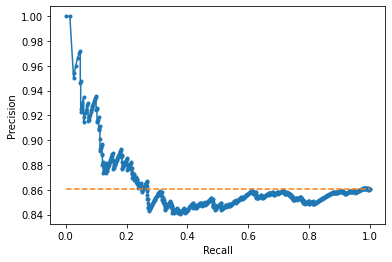

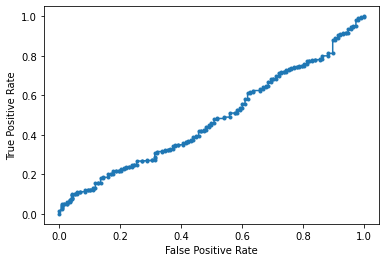

Accuracy: 86.07% Precision: 86.07% Recall: 100.00%
F1: 92.51% MCC: 0.00%
AUPRC: 86.69% AUROC: 47.96%
2023-03-11 21:07:03.045464
Repetition 2 Fold 5
Discriminator ZERO -1
FIT
2023-03-11 21:07:06.474537
PREDICT
2023-03-11 21:07:22.458771
train class weights 1:0  0.58: 3.48
Train 1:0 2902:487 85.63%
Valid 1:0 746:101 88.08%
Predict 1:0 847:0 100.00%


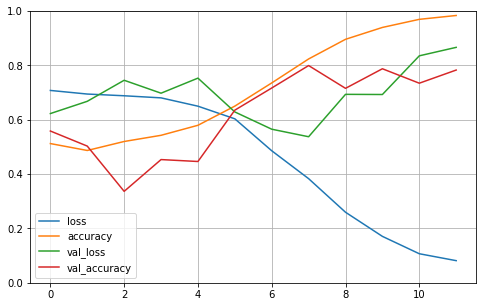

Compute valiation accuracy
Valid sizes (847, 4997) (847,)
Range of scores: 0.00049553404 to 1.0
Score threshold 0.5


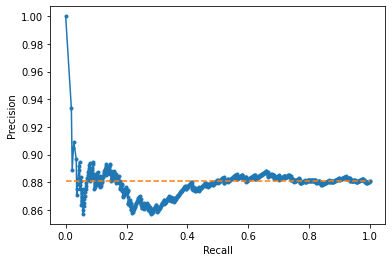

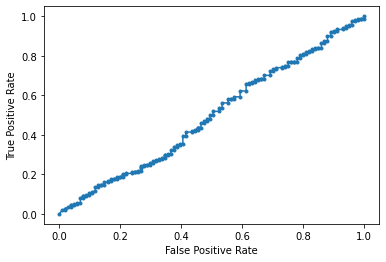

Accuracy: 88.08% Precision: 88.08% Recall: 100.00%
F1: 93.66% MCC: 0.00%
AUPRC: 88.04% AUROC: 49.59%
2023-03-11 21:07:23.201471

Completed cross validation 5 folds 12 epochs
Repeated for a total of 10 folds
 accuracy mean 86.12% std 1.06
 precision mean 86.12% std 1.06
 recall mean 100.00% std 0.00
 F1 mean 92.54% std 0.61
 MCC mean 0.00% std 0.00
 AUPRC mean 87.01% std 1.63
 AUROC mean 50.44% std 2.07

 accuracy [86.55660377358491, 86.06847697756788, 86.89492325855961, 86.65879574970484, 84.4155844155844, 85.49528301886792, 86.18654073199528, 84.7697756788666, 86.06847697756788, 88.07556080283354]
 precision [86.55660377358491, 86.06847697756788, 86.89492325855961, 86.65879574970484, 84.4155844155844, 85.49528301886792, 86.18654073199528, 84.7697756788666, 86.06847697756788, 88.07556080283354]
 recall [100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
 F1 [92.79393173198484, 92.51269035532995, 92.98799747315223, 92.85262492093612, 91.54929577464789, 92.180546726001

In [ ]:
print(datetime.now())
loader = DataLoader()
filepath = DATA_DIR+RCI_FILE
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
print('Load sequence...')
filepath = DATA_DIR+SEQUENCE_FILE
allids,allseq = loader.load_sequence(filepath)
print('Loaded',len(allseq),'sequences.')
loader = None  # drop K-mer cache to save RAM

print("Cross validation...")
cvdo = CrossValidator(EPOCHS,FOLDS,BREAK)
cvdo.set_sequences(allids,allseq)
cvdo.set_rci_map(gene_to_rci)
cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
# two rounds of 5 for 10 total
total_folds = 0
for F in range(2):
    total_folds += FOLDS
    cvdo.do_cross_validation(F+1)   
cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
    cvdo.get_statistics()
cvdo = None

def STD (values):
    return np.std(values,ddof=1)

print("Completed cross validation %d folds %d epochs" % (FOLDS,EPOCHS)) 
print("Repeated for a total of %d folds" % total_folds)
print(" accuracy mean %.2f%% std %.2f" %  (np.mean(cv_accuracy),  STD(cv_accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(cv_precision), STD(cv_precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(cv_recall),    STD(cv_recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(cv_f1),        STD(cv_f1)))
print(" MCC mean %.2f%% std %.2f" %       (np.mean(cv_mcc),       STD(cv_mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(cv_auprc),     STD(cv_auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(cv_auroc),     STD(cv_auroc)))
print()
print(" accuracy" ,  cv_accuracy)
print(" precision" , cv_precision)
print(" recall" ,    cv_recall)
print(" F1" ,        cv_f1)
print(" MCC" ,       cv_mcc)
print(" AUPRC" ,     cv_auprc)
print(" AUROC" ,     cv_auroc)
print(datetime.now())